# The Architecture of the Visual Cortex

# Convolutional Layers

### Filters

### Stacking Multiple Feature Maps

### TensorFlow Implementation

In [15]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl

In [16]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load ảnh mẫu
china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Tạo 2 filter 
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # theo phương đứng
filters[3, :, :, 1] = 1 # theo phương ngang

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
# lệnh dùng để thực hiện phép tích chập 2d trên ảnh

<function matplotlib.pyplot.show(close=None, block=None)>

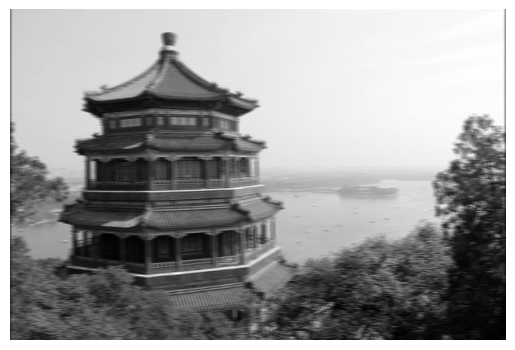

In [17]:
plt.imshow(outputs[0, :, :, 1], cmap="gray") # vẽ hình đầu tiên filter theo phương ngang
plt.axis("off")
plt.show

In [18]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

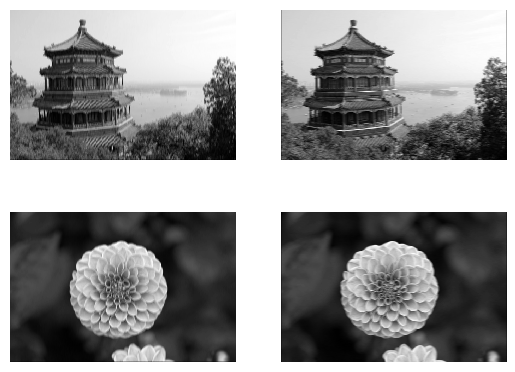

In [19]:
i = 1
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, i)
        plot_image(outputs[image_index, :, :, feature_map_index])
        i += 1 
plt.show()

In [20]:
def crop(images):
    return images[150:220, 130:250]

Text(0.5, 1.0, 'china_original')

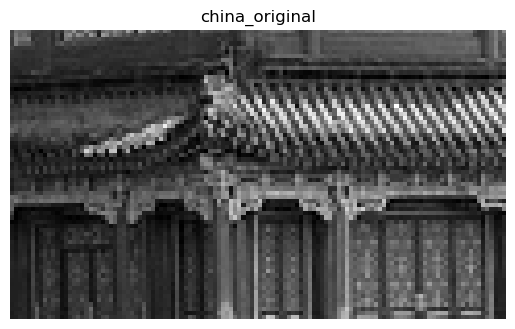

In [21]:
plot_image(crop(images[0, :, :, 0]))
plt.title("china_original")


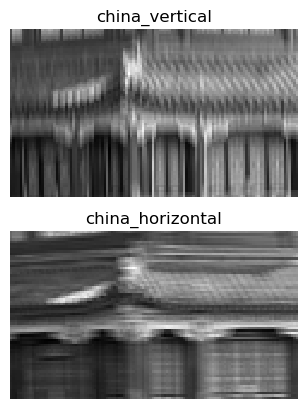

In [22]:
for feature_map_index, name in enumerate(["china_vertical", "china_horizontal"]):
    plt.subplot(2, 1, feature_map_index + 1 )
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.title(name)
plt.show()

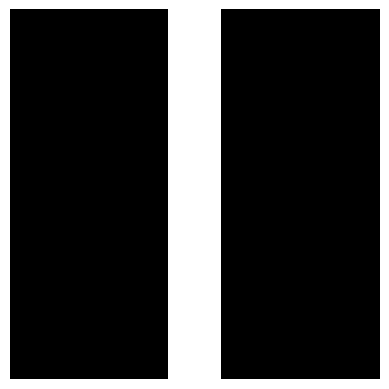

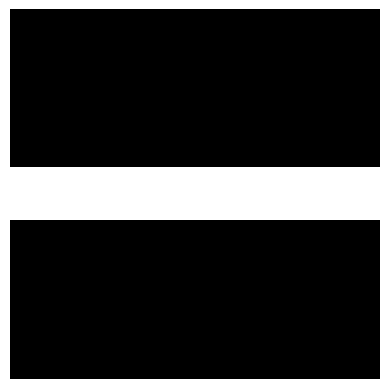

In [23]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

In [24]:
outputs.shape, images.shape

(TensorShape([2, 427, 640, 2]), (2, 427, 640, 3))

In [25]:
np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                          padding="SAME", activation="relu", input_shape=outputs.shape)

In [26]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

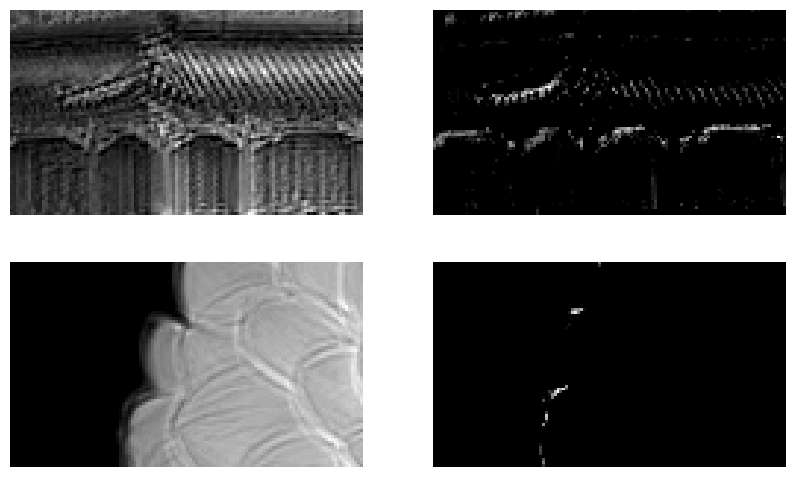

In [27]:
plt.figure(figsize=(10,6))
i = 1;
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, i)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
        i += 1
plt.show()

In [28]:
conv.set_weights([filters, np.zeros(2)]) # 7x7x3x2 vs 2

In [29]:
conv.weights

[<tf.Variable 'conv2d_4/kernel:0' shape=(7, 7, 3, 2) dtype=float32, numpy=
 array([[[[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[1., 0.],
          [1., 0.],
          [1., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]]],
 
 
        [[[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[1., 0.],
          [1., 0.],
          [1., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]]],
 
 
        [[[0., 0.],
          [0., 0.

In [30]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

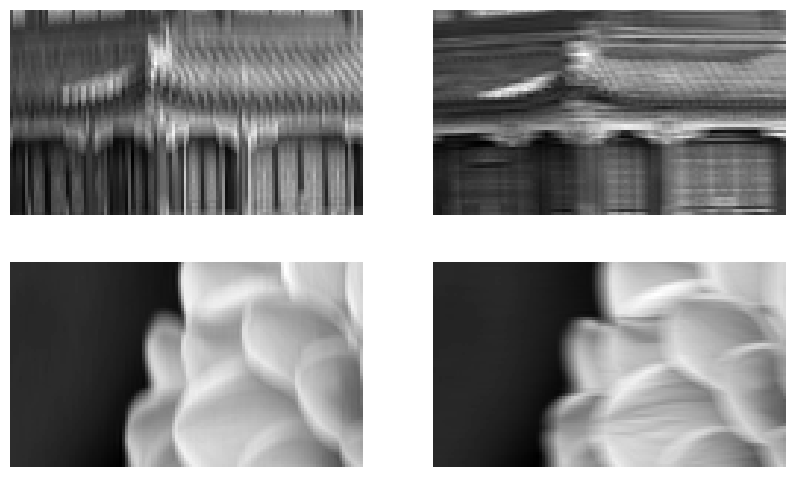

In [31]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

### Memory Requirements

# Pooling Layers

### Max Pooling

In [32]:
max_pool = keras.layers.MaxPool2D(pool_size=2, strides=None) # có kích thước 2x2
# strides = None có kích thước bằng pool_size

In [33]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

In [34]:
cropped_images.shape, output.shape

((2, 70, 120, 3), TensorShape([2, 35, 60, 3]))

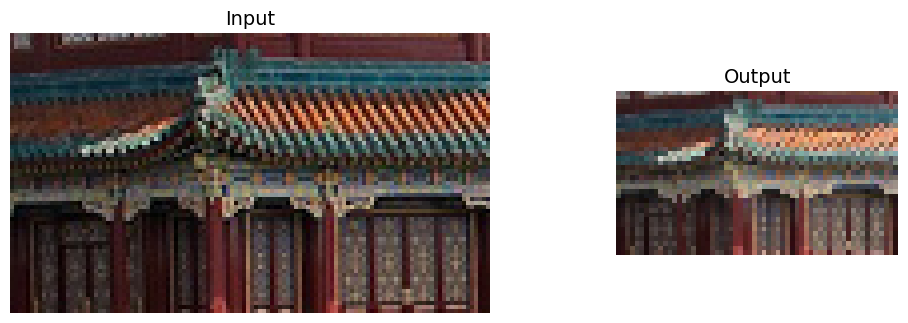

In [35]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[2, 1])
# Tạo ra 1 lưới có 1 hàng và 2 cột với lỉ chiều rộng của các cột trong
# là 2 1 cột đầu 2 cột 2 là 1
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])
ax2.axis("off")
plt.show()

### Depth-wise pooling

In [36]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)
# batch_size, height, width, channels

In [37]:
depth_pool1 = DepthMaxPool(3)

In [38]:
# Có thể sử dụng cách khác
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
# keras.layers.Lambda dùng để tạo 1 layer tuỳ chỉnh phải có lambda ở trong
with tf.device("/cpu:0"): #  GPU-kernel
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

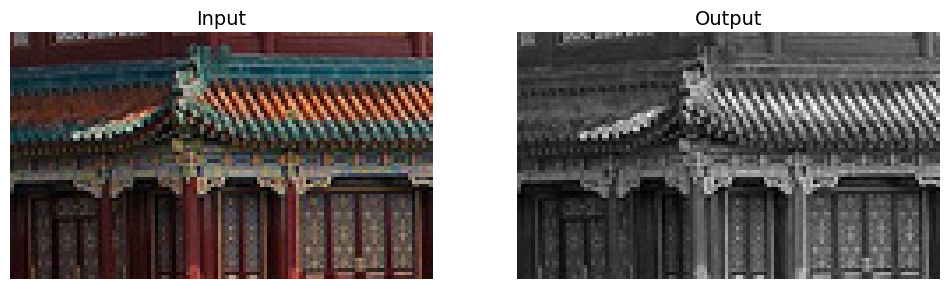

In [39]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

In [40]:
depth_output.shape

TensorShape([2, 70, 120, 1])

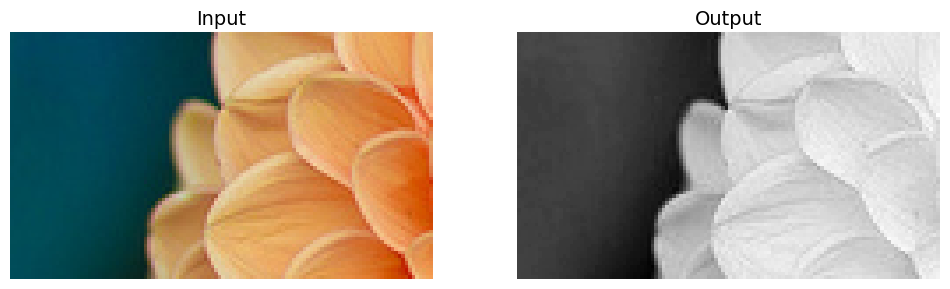

In [41]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[1])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[1, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

### Average pooling

In [42]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [43]:
output_avg = avg_pool(cropped_images)

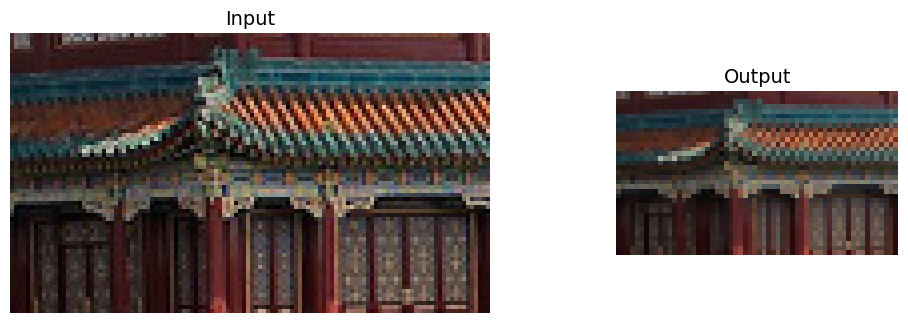

In [44]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[2, 1])
# Tạo ra 1 lưới có 1 hàng và 2 cột với lỉ chiều rộng của các cột trong
# là 2 1 cột đầu 2 cột 2 là 1
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])
ax2.axis("off")
plt.show()

### Global Average Pooling

In [45]:
gobal_avg_pool = keras.layers.GlobalAveragePooling2D()
gobal_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

In [46]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
# tf.reduce_mean dùng để tính giá trị trung bình của các phần tử trong tensor theo 
# trục 1 và 2 
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

# CNN Architectures

In [47]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis] # thêm 1 chiều mới vào ma trận
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [48]:
X_train.shape

(55000, 28, 28, 1)

In [49]:
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu',
                       padding="SAME") # tạo ra những phiên bản hàm mới

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPool2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPool2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation="softmax")
    
])

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 256)         2

In [36]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='nadam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid))




1719/1719 [==============================] - 183s 104ms/step - loss: 0.7055 - accuracy: 0.7570 - val_loss: 0.3584 - val_accuracy: 0.8716


In [37]:
score = model.evaluate(X_test, y_test)

313/313 [==============================] - 10s 31ms/step - loss: 0.3763 - accuracy: 0.8611


In [38]:
X_new = X_test[:10]
y_pred = model.predict(X_new)

1/1 [==============================] - 0s 236ms/step


### LeNet-5

### AlexNet

### GoogleNet

### VGGnet

### ResNet

### Xception

### SENet

# Implementing a ResNet-34 CNN Using Keras

In [51]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs): #input là tham số đầu vào
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [52]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2, 
                       input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_4 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 residual_unit (ResidualUni  (None, 56, 56, 64)        74240     
 t)                                                              
                                                      

# Using Pretrained Models from Keras

In [54]:
model = keras.applications.resnet50.ResNet50(weights='imagenet')
# weights chỉ định trọng số mô hình cần tải, trong trường hợp này trọng số
# đã tải được huấn luyện trong thư viện imagenet

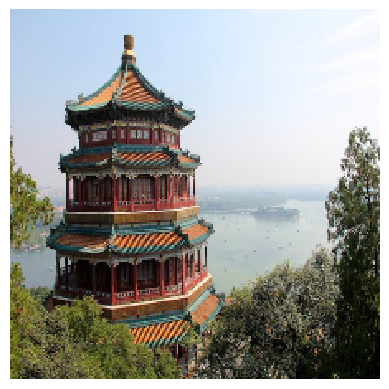

In [55]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

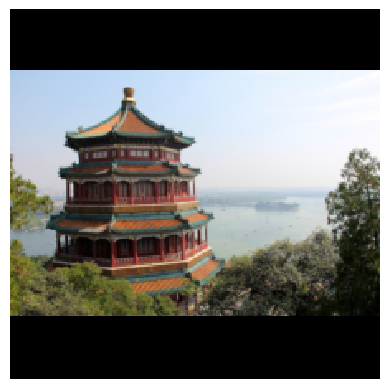

In [56]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True) 
# hàm dùng để thay đổi kích thước ảnh và thêm các padding để đảm bảo đầu ra mong muốn
# antialias bật chế độ chống nhoè
plot_color_image(images_resized[0])

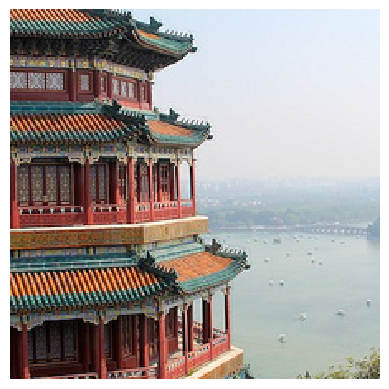

In [57]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
# Y hệt lệnh như trên nhưng buff thêm cut
plot_color_image(images_resized[0])

In [58]:
china_box = [0, 0.03, 1, 0.68] # y1, x1, y2, x2
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
# [0, 1] chỉ định các ảnh được áp dụng trong batch_size

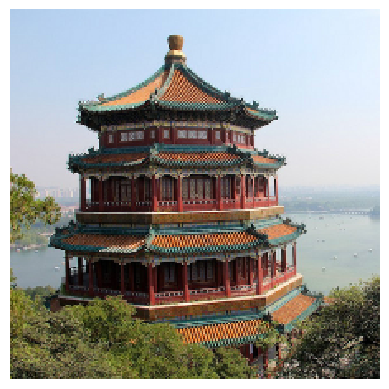

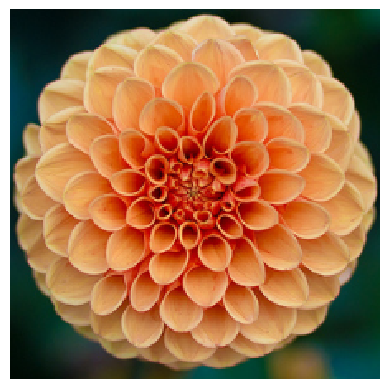

In [59]:
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

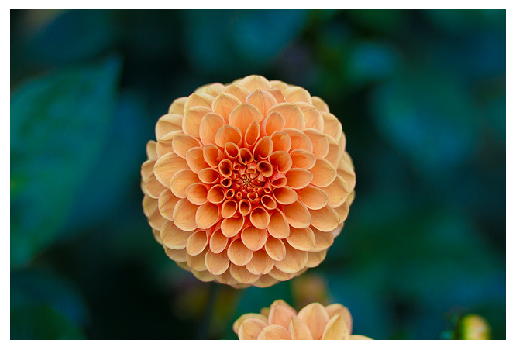

In [60]:
plot_color_image(images[1])

In [61]:
intputs = keras.applications.resnet50.preprocess_input(images_resized*255)
Y_proba = model.predict(intputs)

1/1 [==============================] - 2s 2s/step


In [62]:
Y_proba.shape

(2, 1000)

In [63]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



In [64]:
Y_proba[0].shape

(1000,)

In [65]:
keras.applications.resnet50.decode_predictions(Y_proba[[0]])

[[('n03877845', 'palace', 0.4339365),
  ('n02825657', 'bell_cote', 0.430744),
  ('n03781244', 'monastery', 0.11695058),
  ('n02980441', 'castle', 0.008103259),
  ('n09332890', 'lakeside', 0.0017344708)]]

In [66]:
model_1 = keras.applications.InceptionV3(weights='imagenet')

In [67]:
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [299, 299])

In [68]:
intputs = keras.applications.inception_v3.preprocess_input(images_resized*255)
Y_proba = model_1.predict(intputs)

1/1 [==============================] - 2s 2s/step


In [69]:
top_K = keras.applications.inception_v3.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Image #0
  n03028079 - church       33.07%
  n03877845 - palace       17.78%
  n02825657 - bell_cote    5.83%

Image #1
  n11939491 - daisy        5.44%
  n07714990 - broccoli     3.73%
  n03530642 - honeycomb    3.52%



# Pretrained Models for Transfer Learning

In [70]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
# as_supervised chỉ định liệu muốn tải dữ liệu với cặp (image-label) ko
# with_ifno chỉ định hàm trả về vs các thông tin liên quan đến dữ liệu

In [71]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='C:\\Users\\Admin\\tensorflow_datasets\\tf_flowers\\3.0.1',
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [72]:
info.splits

{'train': <SplitInfo num_examples=3670, num_shards=2>}

In [73]:
info.splits["train"]

<SplitInfo num_examples=3670, num_shards=2>

In [74]:
class_names = info.features['label'].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [75]:
n_classes = info.features["label"].num_classes
n_classes

5

In [76]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [77]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load("tf_flowers",
                                                      split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
                                                      as_supervised=True)

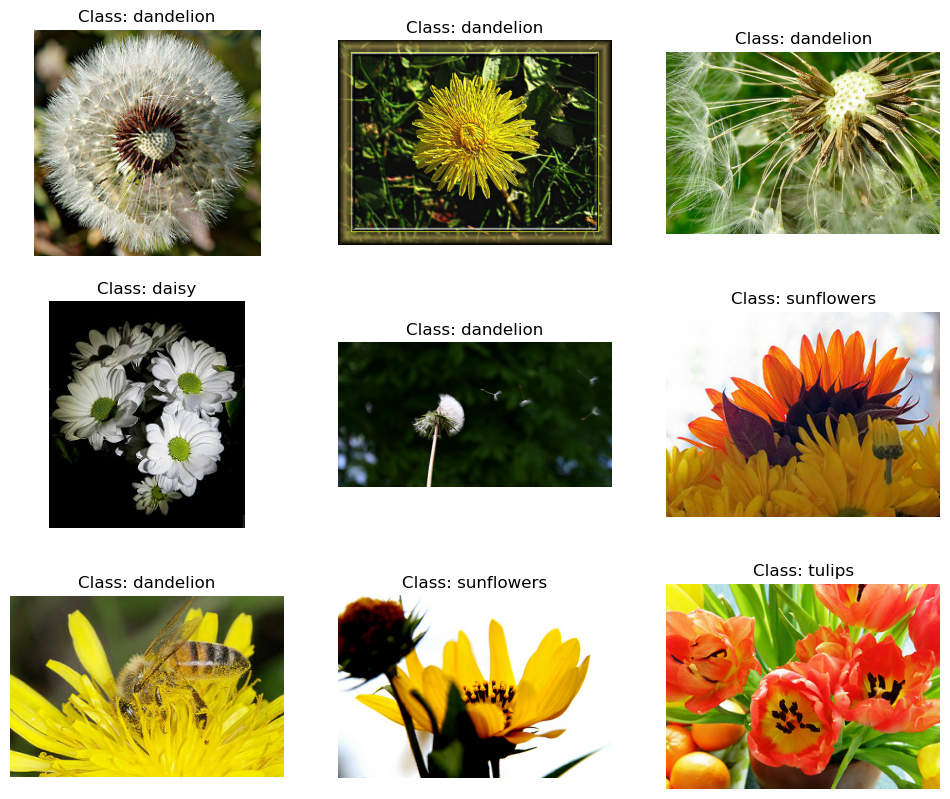

In [78]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

In [79]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [80]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [81]:
np.random.seed(42)
tf.random.set_seed(42)
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat() # tạo chuỗi data vô hạn
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
# prefetch()cho phép cb để tải dữ liệu cho lần lặp tiếp theo
# map hàm đó với tất cả cái imgae trong train_set
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

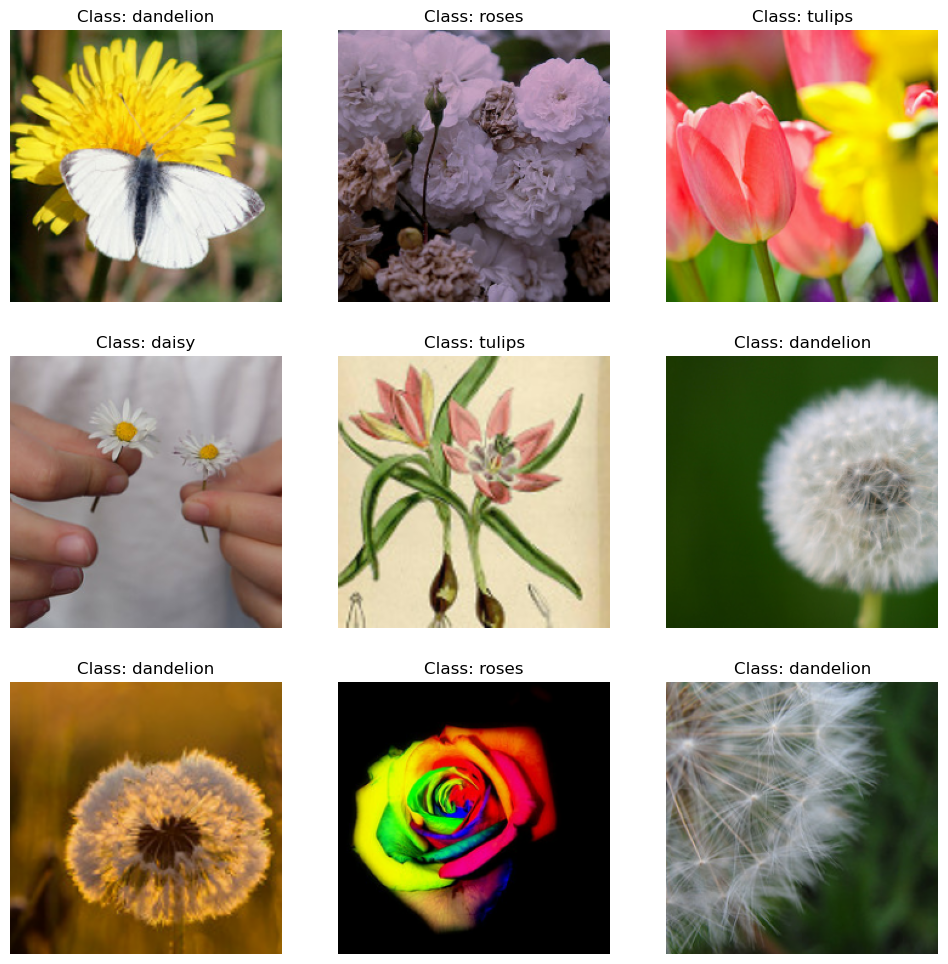

In [82]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [87]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                 include_top=False)
# include_top: có bao gồm các lớp fully conected layer hay không
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [90]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_7
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_152
13 block2_pool
14 batch_normalization_146
15 add_48
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_153
23 block3_pool
24 batch_normalization_147
25 add_49
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_154
33 block4_pool
34 batch_normalization_148
35 add_50
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_51
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn


In [75]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, 
             metrics="accuracy")

In [134]:
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=3) 
#step_per_epoch: số bước cập nhật trong 1 epochs

Epoch 1/3
86/86 [==============================] - 170s 2s/step - loss: 1.1008 - accuracy: 0.7991 - val_loss: 1.2026 - val_accuracy: 0.8548
Epoch 2/3
86/86 [==============================] - 159s 2s/step - loss: 0.8656 - accuracy: 0.8695 - val_loss: 1.4270 - val_accuracy: 0.8529
Epoch 3/3
86/86 [==============================] - 149s 2s/step - loss: 0.6964 - accuracy: 0.8957 - val_loss: 1.7946 - val_accuracy: 0.8419


In [124]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, 
             metrics="accuracy")

In [136]:
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=10)

Epoch 1/10
86/86 [==============================] - 617s 7s/step - loss: 0.4946 - accuracy: 0.8507 - val_loss: 0.6049 - val_accuracy: 0.8603
Epoch 2/10
86/86 [==============================] - 618s 7s/step - loss: 0.1398 - accuracy: 0.9553 - val_loss: 0.3409 - val_accuracy: 0.9007
Epoch 3/10
86/86 [==============================] - 776s 9s/step - loss: 0.0847 - accuracy: 0.9709 - val_loss: 0.3535 - val_accuracy: 0.8934
Epoch 4/10
86/86 [==============================] - 690s 8s/step - loss: 0.0580 - accuracy: 0.9807 - val_loss: 0.2293 - val_accuracy: 0.9320
Epoch 5/10
86/86 [==============================] - 667s 8s/step - loss: 0.0396 - accuracy: 0.9869 - val_loss: 0.2902 - val_accuracy: 0.9154
Epoch 6/10
86/86 [==============================] - 743s 9s/step - loss: 0.0445 - accuracy: 0.9873 - val_loss: 0.3399 - val_accuracy: 0.9191
Epoch 7/10
86/86 [==============================] - 712s 8s/step - loss: 0.0296 - accuracy: 0.9906 - val_loss: 0.2285 - val_accuracy: 0.9357
Epoch 8/10
86

# Classification and Localization


In [125]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],
              optimizer=optimizer, metrics=["accuracy"])

In [126]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

In [127]:
tf.random.uniform([tf.shape(images)[0], 4])
# Lấy số lượng ảnh cũng như đặt 4 giá trị out

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.5749372 , 0.19900596, 0.7038239 , 0.05541027],
       [0.5884645 , 0.5430788 , 0.9185413 , 0.37144518]], dtype=float32)>

In [128]:
fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [129]:
model.fit(fake_train_set,  steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 57s 9s/step - loss: 1.2864 - dense_21_loss: 1.5198 - dense_22_loss: 0.3528 - dense_21_accuracy: 0.3375 - dense_22_accuracy: 0.2937
Epoch 2/2
5/5 [==============================] - 44s 9s/step - loss: 1.1220 - dense_21_loss: 1.3541 - dense_22_loss: 0.1938 - dense_21_accuracy: 0.4625 - dense_22_accuracy: 0.2562


# Object Detection

### Fully Convolutional Networks

### You Only Look Once (YOLO)

In [132]:
### Mean Average Precision

In [95]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))
# np.flip đảo ngược mảng
# np.maximum.accumulate() tích luỹ giá trị lớn nhất từ mỗi phần tử của mảng

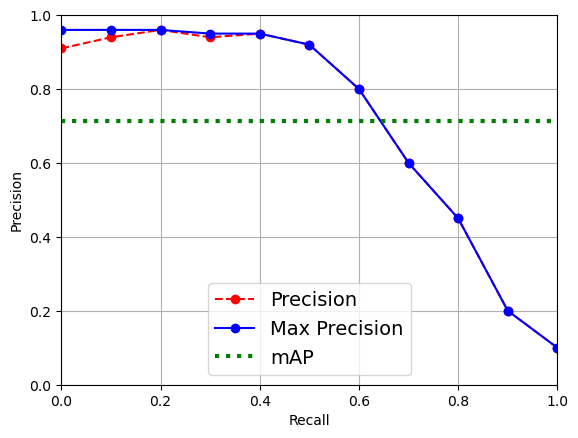

In [152]:
recalls = np.linspace(0, 1, 11) #chia 11 khoảng từ 0 - 1

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

In [205]:
tf.random.set_seed(42)
X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
# Sử dụng phép tích chập ngược nội suy về ảnh ban đầu
output = conv_transpose(X)
output.shape

TensorShape([2, 599, 599, 5])

In [206]:
X.shape

(2, 299, 299, 3)

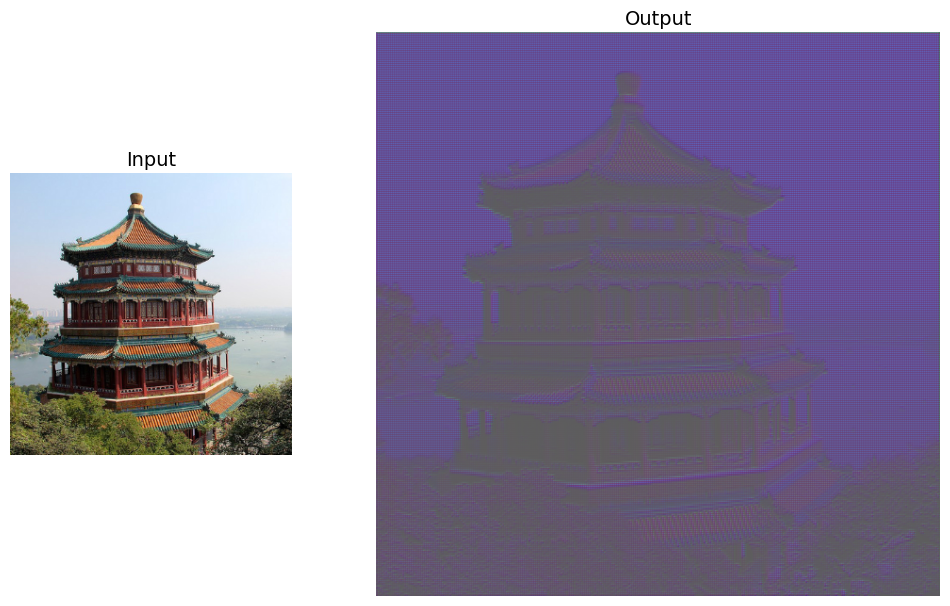

In [207]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))
# tf.reduce_min(X) tính min, max tất cả phần tử trong x của X

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, ...,:3]), interpolation="bicubic")  # plot the output for the 1st image
ax2.axis("off")
plt.show()

# Semantic Segmentation